<a href="https://www.kaggle.com/code/peremartramanonellas/how-to-create-a-siamese-network-to-compare-images?scriptVersionId=124612124" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# Tutorial how to use a Siamese Tewnsorflow Network to identify images
In this notebook we are going to build a Siamese Model with Tensorflow able to compare images and return a difference between them, identifying when images are of the same type.

I used the MNIST Dataset from the Digit Recognizer Competition. This Datset have 42000 images of numbers handwrited. 


## How works a Siamese Network? 
The Network have two inputs, and calculate the euclidean distance between both. 

To calculate the euclidean distance produces two vectors, one per input, and use this vectors to calculate the distance. 



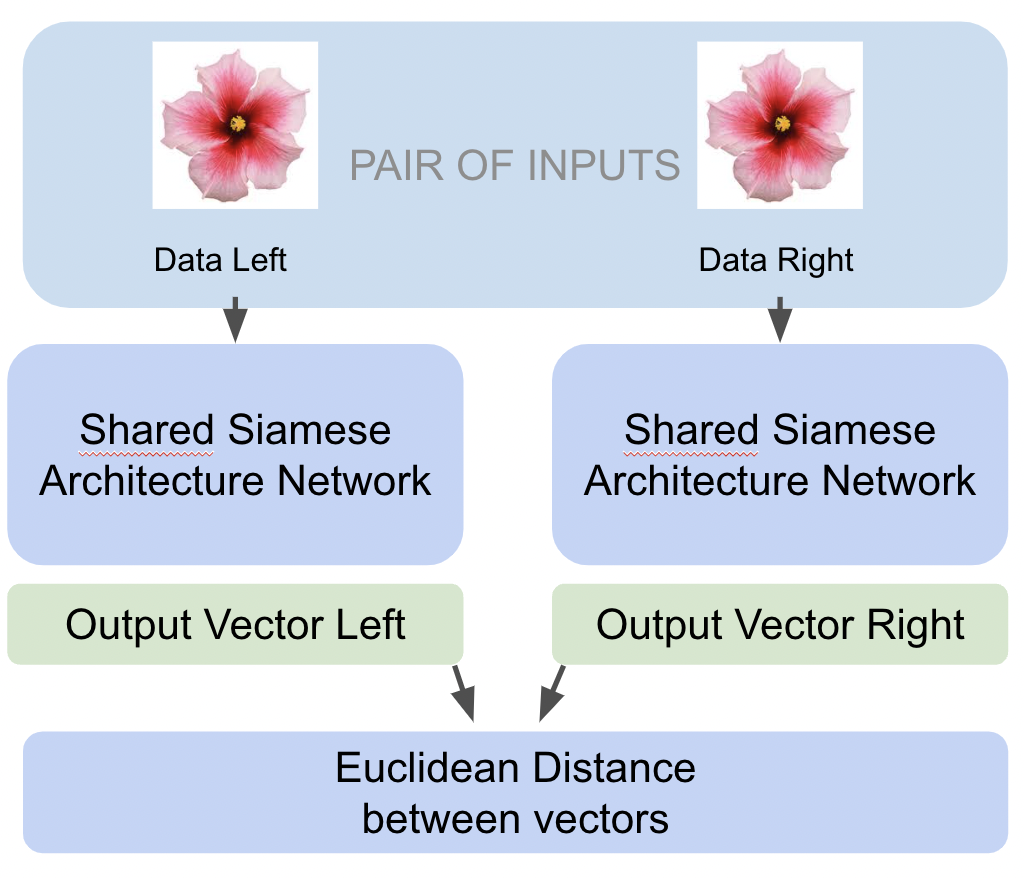


If the items are equal or not is our decission. The model just give us the distance between them. As smaller is the distance more possibilities that the object will be the same. We will receive a 0 for two identical objects. 

## When to use a siamese network. 
The siamese networks are not limited to Image Classification, they can be used to identify similitudes in all kind of data. 

You can identify similarities in text, to identify if is talking about the same theme, or maybe if is a duplicate, or just a copy. 

Is used too, in face recognition. In this case works really fine in one to one recognition, specially if you don't have a big dataset to train the network. 

In [2]:
#Import libraries. 

import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams


# Support Functions
functions to show the images. 

In [3]:
def show_img_dataset(X, y=None, nrows = 4, ncols=4, firstimg=100, numimg=4):
    for i in range(numimg):
        sp = plt.subplot(nrows, ncols, i + 1)

        sp.axis('Off')
        plt.imshow(X[firstimg+i], cmap="Greys")
        if (y is not None): 
            plt.title(y[firstimg+i])    
    plt.show()

As we need to classify the images in pairs to feed the model, I have the function *show_pairs* to display some selected pairs, jus to check if they are correctly classified. 

In [4]:
def show_pairs(X, y, image):
    sp = plt.subplot(1, 2, 1)
    plt.imshow(X[image][0])
    sp = plt.subplot(1, 2, 2)
    plt.imshow(X[image][1])
    plt.figtext(0.5, 0.01, str(y[image]), wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

# Data
We are using the dataset from the competition https://www.kaggle.com/competitions/digit-recognizer

It's a simple Dataset with images of numbers, from 0 to 9,  handwrited. 

In [5]:
#Read the data from CSV files. 
train_df=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

#Obtain Features and labels. 
X = train_df.drop('label', axis=1)
y_train = train_df['label']

X.shape, y_train.shape

((42000, 784), (42000,))

In [6]:
#Reshaping the data loaded from the Excel to have a Image sahpe. 
X_train = np.array(X).reshape((-1, 28, 28, 1))
X_test = np.array(test_df).reshape((-1, 28, 28, 1))
X.shape, X_test.shape

((42000, 784), (28000, 28, 28, 1))

In [7]:
#Normalize the data. 
X_train = X_train.astype('float32') / 255
X_text = X_test.astype('float32') / 255

Show a sample of numbers in the Dataset with his labels. 

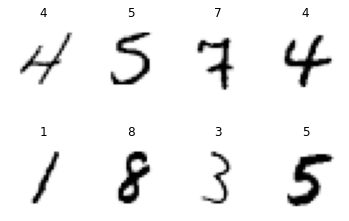

In [8]:
show_img_dataset(X_train, y = y_train, firstimg=700, nrows = 2, ncols=4, numimg=8)

The ***create_pairs*** functions create pairs of numbers from the dataset. Remember, that in the Siamese Network we need to pass a pair of objects and a label indicating if the objects are equal or not. 

Is the label of the number is the same we are going to pass a 1 as a label of the pair,  indicating that are no differences. And if the label of the number is different we will pass an 0, indicating that the numbers are different. 

In [9]:
#The third parameter: min_equals. indicate how many equal pairs, as minimun, we want in the dataset. 
#If we just created random pairs the number of equal pairs would be very small. 
def create_pairs(X, y, min_equals = 3000):
    pairs = []
    labels = []
    equal_items = 0
    
    #index with all the positions containing a same value
    # Index[1] all the positions with values equals to 1
    # Index[2] all the positions with values equals to 2
    #.....
    # Index[9] all the positions with values equals to 9 
    index = [np.where(y == i)[0] for i in range(10)]
    
    for n_item in range(len(X)): 
        if equal_items < min_equals:
            #Select the number to pair from index containing equal values. 
            num_rnd = np.random.randint(len(index[y[n_item]]))
            num_item_pair = index[y[n_item]][num_rnd]

            equal_items += 1
        else: 
            #Select any number in the list 
            num_item_pair = np.random.randint(len(X))
            
        #I'm not checking that numbers is different. 
        #That's why I calculate the label depending if values are equal. 
        labels += [int(y[n_item] == y[num_item_pair])]         
        pairs += [[X[n_item], X[num_item_pair]]]
            
    return np.array(pairs), np.array(labels).astype('float32') 

In [10]:
#Create Train and Validation dataset. 
LIMIT_VAL = 2000
X_train2 = []
y_train2 = []
X_val = X_train[:LIMIT_VAL]
y_val = y_train[:LIMIT_VAL].reset_index(drop=True)
X_train2 = X_train[LIMIT_VAL:]
y_train2 = y_train[LIMIT_VAL:].reset_index(drop=True)

In [11]:
training_pairs, training_labels = create_pairs(X_train2, y_train2, min_equals=15000)
val_pairs, val_labels = create_pairs(X_val, y_val, min_equals=800)

Let's show some pairs from the Train and Validation Dataset. The pairs with equal number are at the beginning of the dataset. 

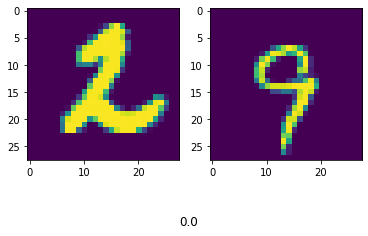

In [12]:
#Different pair of the training set labeled with a 0. 
show_pairs(training_pairs, training_labels, 34004)

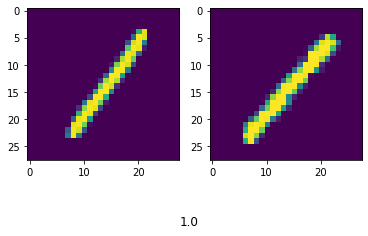

In [13]:
#Same pair of the training set labeled with a 1. 
show_pairs(training_pairs, training_labels, 34)

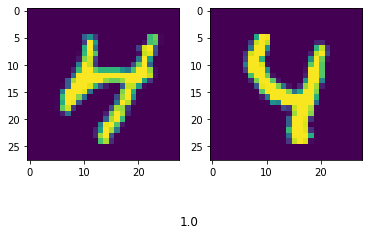

In [14]:
#Similar pair of the validation set labeled with a 1. 
show_pairs(val_pairs, val_labels, 32)

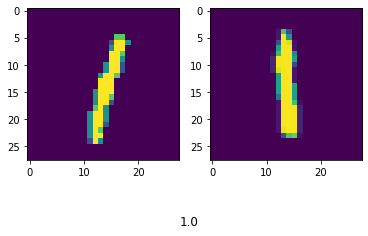

In [15]:
#Different pair of the validation set labeled with a 0. 
show_pairs(val_pairs, val_labels, 1500)

# Creating the Siamese Model
## Necesary functions Siamese Model
These functions are necessary to calculate the Euclidean Distance between the vectors, and for shape the output of the model. 

Both functions will be used in the Output layer of the model, that is a lambda layer who calls to ***euclidean_distance*** with the vectors. 

The ***eucl_dist_output_shapes*** function is passed to the parameter ***output_shape*** of the layer, just to format the output. 

In [16]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

The loss function below, is a Standard in the Siamese Models. 

Contrastive loss takes the output of the network for a positive example and calculates its distance to an example of the same class and contrasts that with the distance to negative examples. Said another way, the loss is low if positive samples are encoded to similar (closer) representations and negative examples are encoded to different (farther) representations.

if you want to know more about the constractive function, check this links: 
https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec
https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

In a plain language: If images are similar, produces a feature vectors that are very similar. If the images are different produce a feature vectos thar are less simmilar, or not similar at all. 

In [17]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

## Commom part Model
This is the common part of the model. I keep it simple because I'm not looking for get a Fantastic Score, it is just an exercise to understand how the Siamese networks work. Despite this, the model works very well. 

If you want, you can adapt a model from other notebook, where I achieved a nice result in the competition: 
https://www.kaggle.com/code/peremartramanonellas/mnist-digit-recognigtion-0-9974-with-tensorflow

Note that the function is returning a Model. 

In [18]:
def initialize_base_branch():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.3, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.3, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    #Returning a Model, with input and outputs, not just a group of layers. 
    return Model(inputs=input, outputs=x)

base_model = initialize_base_branch()

## Siamese part with two inputs
This is the part of the Siamese model. We define two different inputs and a lambda output layer who uses the ***euclidean_distance*** and ***eucl_dist_output_shape*** functions. 

In [19]:
#Input for the left part of the pair. We are going to pass training_pairs[:,0] to his layer. 
input_l = Input(shape=(28, 28,), name='left_input')
#ATENTION!!! base_model is not an function, is model and we are adding our input layer. 
vect_output_l = base_model(input_l)

#Input layer for the right part of the siamse model. Will receive: training_pairs[:,1]
input_r = Input(shape=(28, 28,), name='right_input')
vect_output_r = base_model(input_r)

#The lambda output layer calling the euclidenan distances, will return the difference between both vectors
output = Lambda(euclidean_distance, name='output_layer', 
                output_shape=eucl_dist_output_shape)([vect_output_l, vect_output_r])

#Our model have two inputs and one output. Each of the inputs contains the commom model. 
model = Model([input_l, input_r], output)

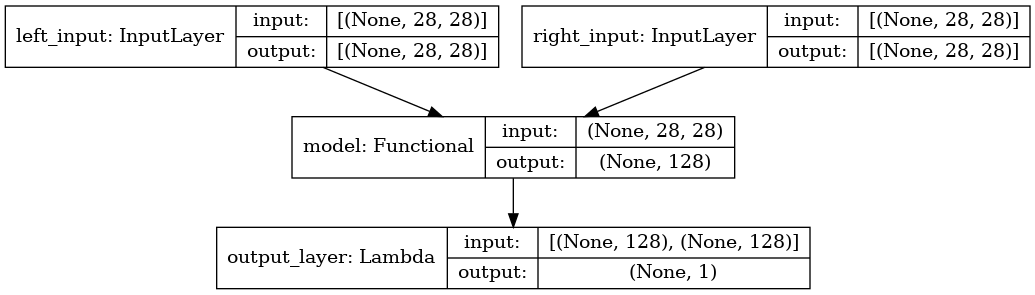

In [20]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='siamese_model.png', show_shapes=True)

## Training the model

In [21]:
rms = RMSprop()
#We use the 'Custom' loss function. And we can pass the margin. I'ts one of the variables
#in the formula, and matain the balance between the value asigned when there arfe similarities or not. 
#with a big value the dissimilarities have more wight than the similarities. 
#you can try different values, I have the impression that we can increase the values and maybe improve 
#a little bit the results. 
#I choose to use an 1. Totally balanced. 
model.compile(loss=contrastive_loss_with_margin(margin=1),
              optimizer=rms)
history = model.fit(
    [training_pairs[:,0], training_pairs[:,1]], 
    training_labels, epochs=20, 
    batch_size=128, 
    validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels))

Epoch 1/20
313/313 [==============================] - 3s 7ms/step - loss: 0.2003 - val_loss: 0.1099
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 0.1154 - val_loss: 0.0719
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0862 - val_loss: 0.0606
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0681 - val_loss: 0.0493
Epoch 5/20
313/313 [==============================] - 3s 8ms/step - loss: 0.0564 - val_loss: 0.0431
Epoch 6/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0486 - val_loss: 0.0375
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0422 - val_loss: 0.0340
Epoch 8/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0388 - val_loss: 0.0350
Epoch 9/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0369 - val_loss: 0.0333
Epoch 10/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0345 - val_loss: 0.0329

## Evaluating Model

In [22]:
#I'm assuming that with a difference less than 0.5 
#the pair images are the same type
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [23]:
y_pred_train = model.predict([training_pairs[:,0], training_pairs[:,1]])
train_accuracy = compute_accuracy(training_labels, y_pred_train)

y_pred_val = model.predict([val_pairs[:,0], val_pairs[:,1]])
val_accuracy = compute_accuracy(val_labels, y_pred_val)

print("Train Accuracy = {} Val accuracy = {}".format(train_accuracy, val_accuracy))

Train Accuracy = 0.988975 Val accuracy = 0.9685


# Check the results
Just two functions to show the images in pairs, with the label beyond. If the label is in red the images are different and if the label is in balck the images are the same type. 

Also the number of the label indicates the amount of differences. As bigger the number more different the images. 

Below the functions I printed three different goups of pairs. Please check if the results are correct. You can see that the classifications would be correct in almost every case. But you can get different results every time you run the ***display_images*** function, because it displays random pairs. 

In [24]:

def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


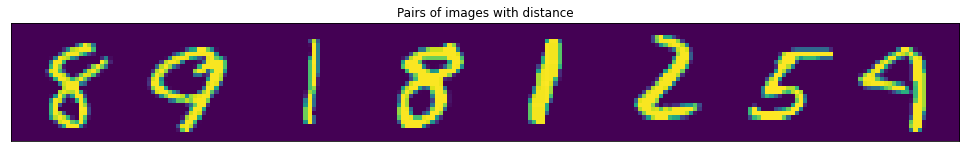

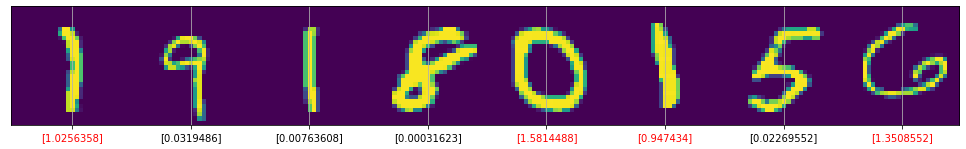

In [25]:
indexes = np.random.choice(len(y_pred_train), size=8)
display_images(training_pairs[:, 0][indexes], 
               training_pairs[:, 1][indexes], 
               y_pred_train[indexes], 
               training_labels[indexes], 
               "Pairs of images with distance", 8)

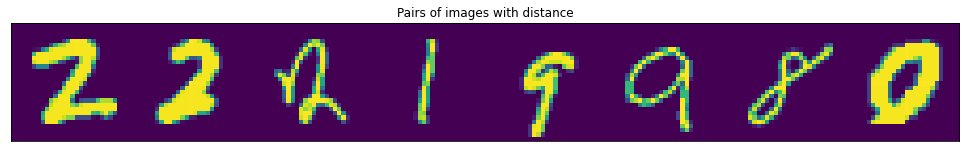

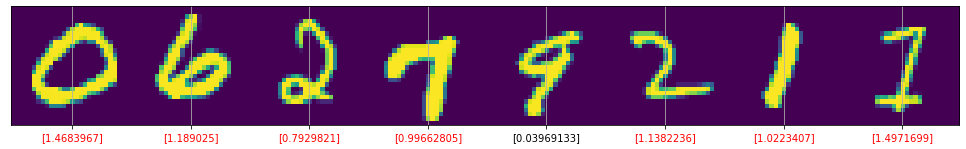

In [26]:
indexes = np.random.choice(len(y_pred_train), size=8)
display_images(training_pairs[:, 0][indexes], 
               training_pairs[:, 1][indexes], 
               y_pred_train[indexes], 
               training_labels[indexes], 
               "Pairs of images with distance", 8)

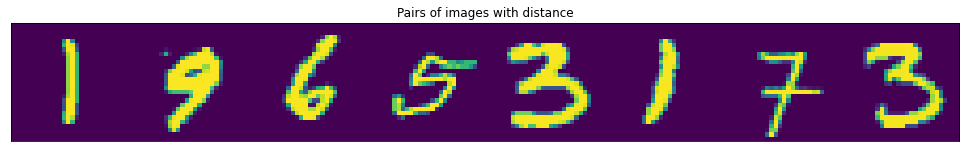

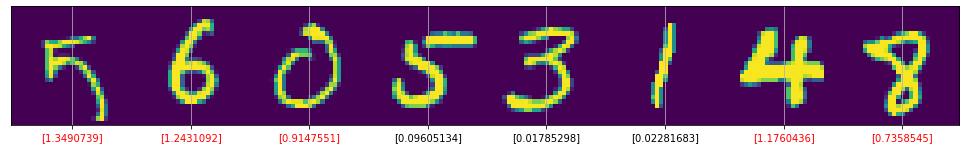

In [27]:
indexes = np.random.choice(len(y_pred_train), size=8)
display_images(training_pairs[:, 0][indexes], 
               training_pairs[:, 1][indexes], 
               y_pred_train[indexes], 
               training_labels[indexes], 
               "Pairs of images with distance", 8)

# Conclusions, Fork & Improve

The Siamese Networks are amazing. You can use it to compare a lot of different thinks, not only Images. It can be used in NLP too, to compare the meaning of a sentence, In Audio recognitions... and of course in Biometry, with facial recognition. 

In this notebook I used it to recognize the digits from the famous MNIST Dataset, and as you can see the result is really good! 

At the time of this writting all the samples taht you can see above are correctly classified. 

To improve the accuracy is possible to modify the base model in the ***initialize_base_branch*** functions. Now it's a really simple model, but if you want you can get som inspiration from the notebook: 
https://www.kaggle.com/code/peremartramanonellas/mnist-digit-recognigtion-0-9974-with-tensorflow
Where I have a more complex model able to achieve a good result in the competition, top 5% if you discard the cheatings. 

A **good and nice experiment can be try to solve the Digit Recornizer competition using this thechnique** if you try it, please share with me the results, I will be realy happy to share your work. 

# Notebooks in the Tensorflow Serie. 
I'm working in a serie of notebooks with some interesting techniques in Tensorflow:  ***Tensorflow beyond the basics***. 

**Multiple outputs with functional keras API** 
https://www.kaggle.com/code/peremartramanonellas/guide-multiple-outputs-with-keras-functional-api
To create Model that can predict more than one variable. 

**Improve Tensorflow performance with Graph mode.**
https://www.kaggle.com/code/peremartramanonellas/improve-tensorflow-performance-with-graph-mode
Compare the Eager vs Graph mode and improve execution of custom models and Data treatment. 